In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS231N/assignments/assignment3/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/CS231N/assignments/assignment3/cs231n/datasets
/content


# Image Captioning with RNNs
В этом упражнении вы создадите стандартные рекуррентные нейронные сети и будете использовать их для обучения модели, способной генерировать новые подписи к изображениям.

## Install h5py
Набор данных COCO, который мы будем использовать, хранится в формате HDF5. Чтобы загрузить файлы HDF5, нам нужно установить пакет Python h5py. Из командной строки запустите: <br/>
`pip install h5py`  <br/>
Если вы получаете сообщение об ошибке прав доступа, вам может потребоваться запустить команду от имени пользователя root: <br/>
```sudo pip install h5py```

Вы также можете запускать команды непосредственно из блокнота Jupyter, добавляя к команде префикс "!":

In [ ]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Microsoft COCO
В этом упражнении мы будем использовать набор данных [Microsoft COCO](http://mscoco.org/) 2014 года, который стал стандартным испытательным стендом для подписей к изображениям. Набор данных состоит из 80 000 обучающих изображений и 40 000 проверочных изображений, каждое из которых снабжено 5 подписями, написанными работниками Amazon Mechanical Turk.


**Вы уже должны были загрузить данные, перейдя в каталог `cs231n/datasets` и запустив скрипт `get_assignment3_data.sh`. Если вы еще этого не сделали, запустите этот скрипт сейчас. Предупреждение: загрузка данных COCO составляет ~ 1 ГБ. **

Мы уже предварительно обработали данные и извлекли для вас признаки. Для всех изображений мы извлекли признаки из слоя fc7 сети VGG-16, предварительно обученной в ImageNet; эти признаки хранятся в файлах `train2014_vgg16_fc7.h5` и `val2014_vgg16_fc7.h5` соответственно. Чтобы сократить время обработки и требования к памяти, мы уменьшили размерность признаков с 4096 до 512; эти признаки можно найти в файлах `train2014_vgg16_fc7_pca.h5` и `val2014_vgg16_fc7_pca.h5`.

Необработанные изображения занимают много места (почти 20 ГБ), поэтому мы не включили их в загрузку. Однако все изображения взяты из Flickr, а URL-адреса обучающих и проверочных изображений хранятся в файлах `train2014_urls.txt` и `val2014_urls.txt` соответственно. Это позволяет загружать изображения на лету для визуализации. Поскольку изображения загружаются на лету, **вы должны быть подключены к Интернету для просмотра изображений**.

Работа со строками неэффективна, поэтому мы будем работать с закодированной версией подписей. Каждому слову присваивается целочисленный ID, что позволяет нам представить подпись последовательностью целых чисел. Сопоставление между целочисленными ID и словами находится в файле `coco2014_vocab.json`, и вы можете использовать функцию `decode_captions` из файла `cs231n/coco_utils.py`, чтобы преобразовать массивы numpy целых идентификаторов обратно в строки.

Есть пара специальных токенов, которые мы добавляем в словарь. Мы добавляем специальный токен `<START>` и добавляем токен `<END>` в начало и конец каждой подписи соответственно. Редкие слова заменяются специальным токеном `<UNK>` (для «неизвестного»). Кроме того, поскольку мы хотим тренироваться с мини-пакетами, содержащими подписи разной длины, мы дополняем короткие подписи специальным токеном `<NULL>` после токена `<END>` и не вычисляем потери или градиент для `<NULL>. ` токенов. Поскольку они немного утомительны, мы позаботились обо всех деталях реализации специальных токенов для вас.

Вы можете загрузить все данные MS-COCO (подписи, признаки, URL-адреса и словарь), используя функцию `load_coco_data` из файла `cs231n/coco_utils.py`. Для этого запустите следующую ячейку:

In [3]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/My Drive/CS231N/assignments/assignment3/cs231n/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Look at the data
Всегда полезно просмотреть примеры из набора данных, прежде чем работать с ним.

Вы можете использовать функцию `sample_coco_minibatch` из файла `cs231n/coco_utils.py` для выборки мини-пакетов данных из структуры данных, возвращенной из `load_coco_data`. Запустите следующее, чтобы отобрать небольшой пакет обучающих данных и отобразить изображения и подписи к ним. Запуск его множество раз и просмотр результатов поможет вам получить представление о наборе данных.

Обратите внимание, что мы декодируем подписи с помощью функции `decode_captions` и загружаем изображения на лету, используя их URL-адрес Flickr, поэтому **вы должны быть подключены к Интернету для просмотра изображений**.

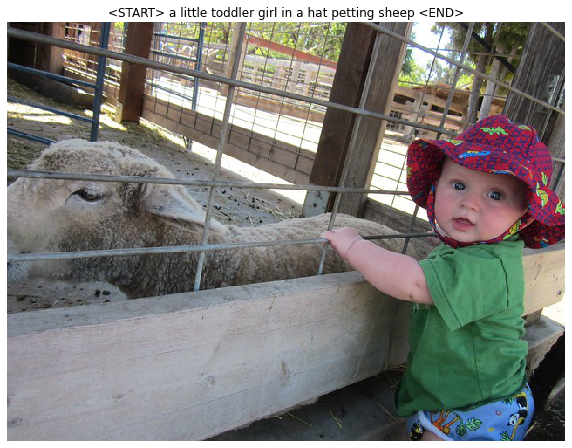

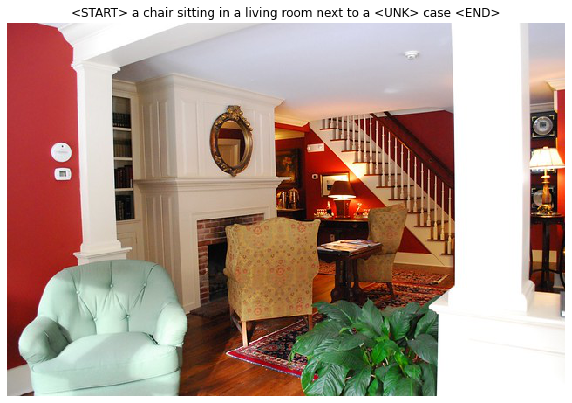

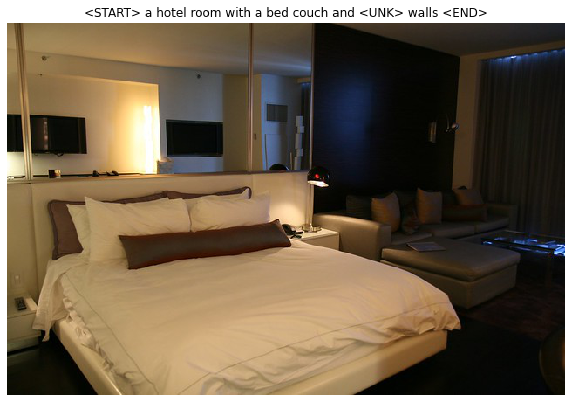

In [4]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Networks

Как обсуждалось в лекции, мы будем использовать языковые модели рекуррентных нейронных сетей (RNN) для подписи к изображениям. Файл `cs231n/rnn_layers.py` содержит реализации различных типов слоев, необходимых для рекуррентных нейронных сетей, а файл `cs231n/classifiers/rnn.py` использует эти слои для реализации модели подписи изображений.

Сначала мы реализуем различные типы слоев RNN в `cs231n/rnn_layers.py.`

In [7]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2])
np.add.at(a, [1, 3], b)
a

array([1, 3, 3, 6])

# Vanilla RNN: step forward

Откройте файл `cs231n/rnn_layers.py`. Этот файл реализует прямой и обратный проходы для различных типов слоев, которые обычно используются в рекуррентных нейронных сетях.

Сначала реализуйте функцию `rnn_step_forward`, которая реализует прямой проход для одного временного шага обычной рекуррентной нейронной сети. После этого выполните следующее, чтобы проверить свою реализацию. Вы должны увидеть ошибки порядка e-8 или меньше.

In [ ]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward

В файле `cs231n/rnn_layers.py` реализуем функцию `rnn_step_backward`. После этого запустите следующее, чтобы численно проверить вашу реализацию градиента. Вы должны увидеть ошибки порядка `e-8` или меньше.

In [ ]:
from cs231n.rnn_layers import rnn_step_forward, rnn_step_backward
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.0192769090159184e-10
dprev_h error:  2.5632975303201374e-10
dWx error:  8.820222259148609e-10
dWh error:  4.703287554560559e-10
db error:  7.30162216654e-11


# Vanilla RNN: forward

Теперь, когда вы реализовали прямой и обратный проходы для одного временного шага обычной RNN, вы объедините эти части для реализации RNN, которая обрабатывает всю последовательность данных.

В файле `cs231n/rnn_layers.py` реализуйте функцию `rnn_forward`. Это должно быть реализовано с помощью функции `rnn_step_forward`, которую вы определили выше. После этого выполните следующее, чтобы проверить свою реализацию. Вы должны увидеть ошибки порядка `e-7` или меньше.

In [ ]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466158305164e-08


# Vanilla RNN: backward

В файле `cs231n/rnn_layers.py` реализуйте обратный проход для ванильного RNN в функции `rnn_backward`. Это должно запустить обратное распространение по всей последовательности, вызывая функцию `rnn_step_backward`, которую вы определили ранее. Вы должны увидеть ошибки порядка e-6 или меньше.

In [ ]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.5382468491701097e-09
dh0 error:  3.3839681556240896e-09
dWx error:  7.150535245339328e-09
dWh error:  1.297338408201546e-07
db error:  1.4889022954777414e-10


# Word embedding: forward

В системах глубокого обучения мы обычно представляем слова с помощью векторов. Каждое слово словаря будет связано с вектором, и эти векторы будут изучаться вместе с остальной частью системы.

В файле `cs231n/rnn_layers.py` реализовать функцию` word_embedding_forward`, чтобы преобразовать слова (представленные целыми числами) в векторы. Запустите следующее, чтобы проверить свою реализацию. Вы должны увидеть ошибку порядка `e-8` или меньше.

In [8]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# Word embedding: backward

Реализуйте обратный проход для функции встраивания слов в функцию `word_embedding_backward`. После этого запустите следующее, чтобы численно проверить вашу реализацию градиента. Вы должны увидеть ошибку порядка `e-11` или меньше.

In [15]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


# Temporal Affine layer

На каждом временном шаге мы используем аффинную функцию для преобразования скрытого вектора RNN на этом временном шаге в оценки для каждого слова в словаре. Поскольку это очень похоже на аффинный слой, который вы реализовали в assignment 2, мы предоставили вам эту функцию в функциях `temporal_affine_forward` и `temporal_affine_backward` в файле `cs231n/rnn_layers.py`. Выполните следующую команду, чтобы выполнить численную проверку реализации  градиента. Вы должны увидеть ошибки порядка e-9 или меньше.

In [16]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  2.9215945034030545e-10
dw error:  1.5772088618663602e-10
db error:  3.252200556967514e-11


# Temporal Softmax loss

В языковой модели RNN на каждом временном шаге мы получаем оценку для каждого слова в словаре. Мы знаем истинное слово на каждом временном шаге, поэтому мы используем функцию потерь softmax для вычисления потерь и градиента на каждом временном шаге. Мы суммируем потери по времени и усредняем их по мини-партии.

Однако есть один нюанс: поскольку мы работаем с мини-пакетами и разные подписи могут иметь разную длину, мы добавляем токены `<NULL>` в конец каждой подписи, чтобы все они имели одинаковую длину. Мы не хотим, чтобы эти токены `<NULL>` учитывались в счет потери или градиента, поэтому в дополнение к оценкам и достоверным меткам (ground-truth)  наша функция потерь также принимает массив `mask`, который сообщает ей, какие элементы оценок учитываются в отношении потерь.

Поскольку это очень похоже на функцию потерь softmax, которую вы реализовали в assignment 1, мы реализовали эту функцию потерь для вас; посмотрите на функцию `temporal_softmax_loss` в файле `cs231n/rnn_layers.py`.

Запустите следующую ячейку, чтобы проверить потери и выполните численную проверку градиента для функции. Вы должны увидеть ошибку для dx порядка e-7 или меньше.

In [17]:
# Sanity check for temporal softmax loss
from cs231n.rnn_layers import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be within 2.2-2.4

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3027781774290146
23.025985953127226
2.2643611790293394
dx error:  2.583585303524283e-08


# RNN for image captioning

Теперь, когда вы реализовали необходимые слои, вы можете объединить их для создания модели подписывания изображений. Откройте файл `cs231n/classifiers/rnn.py` и посмотрите на класс `CaptioningRNN`.

Реализуйте прямой и обратный проход модели в функции `loss`. На данный момент вам нужно только реализовать случай, когда `cell_type='rnn'` для RNN vanialla; вы реализуете случай LSTM позже. После этого запустите следующее, чтобы проверить ваш прямой проход, используя небольшой тестовый пример; вы должны увидеть ошибку порядка `e-10` или меньше.

In [ ]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

Запустите следующую ячейку, чтобы выполнить проверку числового градиента в классе `CaptioningRNN`; вы должны увидеть ошибки порядка `e-6` или меньше.

In [ ]:
np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='rnn',
          dtype=np.float64,
        )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

# Overfit small data

Подобно классу `Solver`, который мы использовали для обучения моделей классификации изображений в предыдущем задании, в этом задании мы используем класс `CaptioningSolver` для обучения моделей подписывающих изображения. Откройте файл `cs231n/captioning_solver.py` и прочитайте класс `CaptioningSolver`; это должно выглядеть очень знакомо.

После того, как вы ознакомились с API, выполните следующее, чтобы убедиться, что ваша модель переобучается на небольшой выборке из 100 обучающих примеров. Вы должны увидеть окончательную потерю менее 0.1.

In [ ]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Распечатайте окончательный training loss. Вы должны увидеть окончательную потерю менее 0.1.

In [ ]:
print('Final loss: ', small_rnn_solver.loss_history[-1])

# Test-time sampling
В отличие от моделей классификации, модели подписей к изображениям ведут себя сильно различно во время обучения и во время тестирования. Во время обучения у нас есть доступ к достоверной подписи, поэтому мы передаем достоверные слова в качестве входных данных для RNN на каждом временном шаге. Во время тестирования мы делаем выборку из распределения по словарю на каждом временном шаге и подаем образец в качестве входных данных для RNN на следующем временном шаге.

В файле `cs231n/classifiers/rnn.py` реализуйте метод `sample` для выборки во время тестирования. После этого запустите следующее, чтобы выбрать из вашей переобученной модели как данные обучения (train), так и данные проверки (val). Образцы обучающих данных должны быть очень хорошими; образцы данных проверки, вероятно, не будут иметь смысла.

In [ ]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# INLINE QUESTION 1

В нашей текущей настройке подписывания наша языковая модель RNN создает слово на каждом временном шаге в качестве вывода. Однако альтернативный способ постановки проблемы состоит в том, чтобы научить сеть работать с _characters_ (например, «a», «b» и т. д.), а не со словами, чтобы на каждом временном шаге она получала предыдущий символ в качестве входных данных. и пытается предсказать следующий символ в последовательности. Например, сеть может сгенерировать заголовок, например

'A', ' ', 'c', 'a', 't', ' ', 'o', 'n', ' ', 'a', ' ', 'b', 'e', 'd'

Можете ли вы описать одно из преимуществ модели подписей к изображениям, в которой используется RNN на уровне символов? Можете ли вы также описать один недостаток? СОВЕТ: есть несколько правильных ответов, но может быть полезно сравнить пространство параметров моделей на уровне слов и на уровне символов.

**Your Answer:** 

